# 通し課題　DAY3
Theme : Car consume

■分析のシナリオ

１．必要なライブラリーの読み込み  DAY1

２．csvデータの読み込みと確認  DAY1

３．前処理　DAY1-DAY2  
         ・欠損値補完  
         ・質的データの整理とダミーデータ化  
         ・量的データの標準化  
         ・外れ値の確認と削除
         ・べき乗分布の変換
         
４．分析　　DAY3  
    4.1：特徴量選択(埋め込み法)　×　回帰分析  
    4.2：木分析  
         ・決定木回帰問題　×　クロスバリデーション  
         ・ランダムフォレスト  ×　クロスバリデーション  
    4.3：NN  
         ・NuralNet
         ・アンサンブル学習　×　NN




# データの説明

■量的データ  
distance : 走行距離(km)  
consume : 目的変数燃費(L/100km)  
speed : 平均走行時速(km/h)  
temp_inside :　車室内温度(℃)  
temp_outside : 車室外温度(℃)  
refill liters : 再給油量(L)   


■質的データ  
specials: 特別な出来事の記述  
gas_type: E10 or SP98  
rain: 雨が降ったか  
sun: 乗車時暑いと感じたとき  
refill gas: 再給油のガス種類　(※gas_typeの情報を引き継いでいるので今回使用しない)  


# 参考URL
前処理がわかりやすかった。　http://sinhrks.hatenablog.com/entry/2016/02/01/080859

In [1]:
# DAY1
###　１．必要なライブラリーの読み込み）################################



%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC

from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import datetime


# from matplotlib.font_manager import FontProperties
# fp = FontProperties(fname=r'C:\WINDOWS\Fonts\YuGothic.ttf', size=14)

In [2]:
# DAY1
### ２．データの読込みと確認）################################


# csvデータの読込み
df = pd.read_csv('measurements.csv')


# データの確認
print(df.dtypes)
display(df.head())
df.describe()


distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill_liters    object
refill_gas       object
dtype: object


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


In [3]:
# DAY1
## データ型の変換


# object型になっている量的データをfloat型に変換し,を.に修正
df.distance = df.distance.str.replace(',', '.').astype(float)
df.consume = df.consume.str.replace(',', '.').astype(float)
df.temp_inside = df.temp_inside.str.replace(',', '.').astype(float)
df.refill_liters = df.refill_liters.str.replace(',', '.').astype(float)

# 欠損値NaNの確認
print(df.isnull().any(axis=0))

# データの確認
display(df.head())
df.describe()

distance         False
consume          False
speed            False
temp_inside       True
temp_outside     False
specials          True
gas_type         False
AC               False
rain             False
sun              False
refill_liters     True
refill_gas        True
dtype: bool


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill_liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [4]:
# DAY2
###　前処理 ################################

##　欠損値の補完

# 欠損値の補完
df.refill_liters = df.refill_liters.fillna(0)                             # reill_litersがNaNの場合、再給油なしと解釈しNaN=0とした
df.temp_inside = df.temp_inside.fillna(np.nanmean(df.temp_inside))        # temp_insideがNaNの場合、temp_insideの平均値を代入
df.specials = df.specials.fillna('nothing')                               # specialsがNaNのとき、nothing標記に変更
df = df.drop("refill_gas", axis=1)                                        # refill_gasはgas_typeを引き継いでいるため削除

# 欠損値NaNの確認
print(df.isnull().any(axis=0))

# データの確認
display(df.head())
df.describe()

distance         False
consume          False
speed            False
temp_inside      False
temp_outside     False
specials         False
gas_type         False
AC               False
rain             False
sun              False
refill_liters    False
dtype: bool


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters
0,28.0,5.0,26,21.5,12,nothing,E10,0,0,0,45.0
1,12.0,4.2,30,21.5,13,nothing,E10,0,0,0,0.0
2,11.2,5.5,38,21.5,15,nothing,E10,0,0,0,0.0
3,12.9,3.9,36,21.5,14,nothing,E10,0,0,0,0.0
4,18.5,4.5,46,21.5,15,nothing,E10,0,0,0,0.0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill_liters
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,1.243557
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.267443,0.329677,0.275441,6.856419
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


Text(0, 0.5, 'degree')

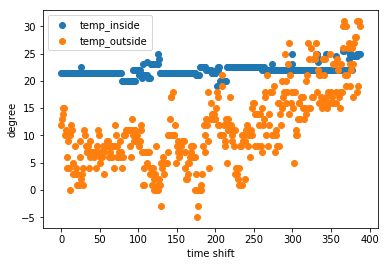

In [5]:
# DAY2
## temp_insideの欠損値補完について

#　時系列データとしてみた場合、季節変動などがあるので、欠損値近傍での平均化の方がベターか？
#　まずは、可視化で傾向を捉える

plt.scatter(np.arange(0,len(df['temp_inside'])), df['temp_inside'], label='temp_inside')          # 車室内
plt.scatter(np.arange(0,len(df['temp_outside'])), df['temp_outside'], label='temp_outside')       # 車室外
plt.legend()
plt.xlabel('time shift')
plt.ylabel('degree')

コメント：  
１．車室外の気温に比べ、車室内の気温は振れ幅が少なく安定しているため、欠損値の補完は全体平均値で問題ないとした。  
２．車室外の気温は右上がりな傾向(冬⇒春)が見られ、temp_outsideを補完する場合は時系列性を考慮すべきだと感じる。  

In [6]:
# DAY2
# ##　変数の追加
# # 車室内と外の温度差によりACを使用したり、エンジンの熱変換などの燃費性能が変化することが考えられる。
# # まずは可視化してみる。

# #　車室内外気温差変数
# temp_inout = []
# temp_inout = df['temp_inside'] - df['temp_outside']


# # 気温差と燃費の回帰分析も一応行ってみる
# y = df["consume"].values  #目的変数
# x = temp_inout.values     #説明変数
# X = x.reshape(-1,1)

# regr = LinearRegression(fit_intercept=True)
# regr.fit(X, y)
# y_est_sklearn = regr.intercept_ + regr.coef_[0] * x


# # グラフ表示
# plt.plot(temp_inout, df['consume'], 'o')  
# plt.legend()
# plt.xlabel('temp_inout')
# plt.ylabel('consume')
# plt.plot(x, y_est_sklearn)
# plt.show()


# # データフレームに新変数を格納し確認
# df['temp_inout'] = temp_inout
# display(df.head())
# df.describe()

コメント：  
車室内外の気温差を新変数として追加しようとしたが、車室外の気温と非常に相関が高く(車室内音がほぼコンスタントな値を取っているため、車室外の相対的な値の変化に留まってしまう)使うのをやめた。

In [7]:
# DAY2
## 質的データの整理とダミーデータ化

# specialsの文字列整理（大文字と小文字,単語順序）
df.specials = df.specials.str.lower()
df.specials = df.specials.replace("sun ac", "ac sun")


# 質的データの中身確認
print('specialの中身：' + str(df.specials.unique()))  
print('gas typeの中身：' + str(df.gas_type.unique()))  
print('ACの中身：' + str(df.AC.unique())) 
print('rainの中身：' + str(df.rain.unique()))  
print('sunの中身：' + str(df.sun.unique()))    


# 質的データを量的データ(ダミーデータ)に変換
# E10 = 0, SP98 = 1
df.loc[df['gas_type'] == 'E10', 'gas_type'] = 0
df.loc[df['gas_type'] == 'SP98', 'gas_type'] = 1


# specialsの中のデータをonehotに変換
df = pd.get_dummies(df)                               # objectかカテゴリデータのみがonehot化される


# データ確認
display(df.head())
df.describe()



specialの中身：['nothing' 'ac rain' 'ac' 'rain' 'snow' 'ac snow' 'half rain half sun'
 'sun' 'ac sun']
gas typeの中身：['E10' 'SP98']
ACの中身：[0 1]
rainの中身：[0 1]
sunの中身：[0 1]


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,28.0,5.0,26,21.5,12,0,0,0,0,45.0,0,0,0,0,0,1,0,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
3,12.9,3.9,36,21.5,14,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
4,18.5,4.5,46,21.5,15,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.587629,0.077320,0.123711,0.082474,1.243557,0.036082,0.025773,0.002577,0.012887,0.002577,0.760309,0.082474,0.007732,0.069588
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441,6.856419,0.186736,0.158663,0.050767,0.112931,0.050767,0.427446,0.275441,0.087704,0.254779
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# DAY2
#　specialsの組み合わせを使うか、AC, rain, sunのもともとの変数を使うかで迷ったため、dfを2バージョン作成し精度を比較できるようにしておく。
#　df1はAC, rain, sun、　df2はspecialsをonehot化したもの

df1 = df[["distance", "consume", "speed", "temp_inside", "temp_outside", "gas_type", "AC", "rain", "sun", "refill_liters"]]
df2 = df.drop(columns=["AC", "rain", "sun"], axis=1)

# データ確認
display(df1.head())
display(df2.head())

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,28.0,5.0,26,21.5,12,0,0,0,0,45.0
1,12.0,4.2,30,21.5,13,0,0,0,0,0.0
2,11.2,5.5,38,21.5,15,0,0,0,0,0.0
3,12.9,3.9,36,21.5,14,0,0,0,0,0.0
4,18.5,4.5,46,21.5,15,0,0,0,0,0.0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,28.0,5.0,26,21.5,12,0,45.0,0,0,0,0,0,1,0,0,0
1,12.0,4.2,30,21.5,13,0,0.0,0,0,0,0,0,1,0,0,0
2,11.2,5.5,38,21.5,15,0,0.0,0,0,0,0,0,1,0,0,0
3,12.9,3.9,36,21.5,14,0,0.0,0,0,0,0,0,1,0,0,0
4,18.5,4.5,46,21.5,15,0,0.0,0,0,0,0,0,1,0,0,0


コメント：  
specialsをonehot化したものは(snowも含む)各組合せ分あるため項目数は増える。

In [9]:
# DAY2
##　量的データの標準化
# scipyによる標準化

# df1_norm = df1
# df2_norm = df2
df1_norm = df1.copy()
df2_norm = df2.copy()
# df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']] = scipy.stats.zscore(df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']])
# df2_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']] = scipy.stats.zscore(df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']])
df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df1.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])
df2_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df1.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])



# データ確認
display(df2_norm.head())
df2_norm.describe()

display(df2.head())
df2.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,0.368714,0.084925,-1.172804,-0.432382,0.091908,0,6.390062,0,0,0,0,0,1,0,0,0
1,-0.338044,-0.690390,-0.878274,-0.432382,0.235123,0,-0.181605,0,0,0,0,0,1,0,0,0
2,-0.373381,0.569497,-0.289216,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0
3,-0.298288,-0.981133,-0.436480,-0.432382,0.378338,0,-0.181605,0,0,0,0,0,1,0,0,0
4,-0.050923,-0.399647,0.299843,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,28.0,5.0,26,21.5,12,0,45.0,0,0,0,0,0,1,0,0,0
1,12.0,4.2,30,21.5,13,0,0.0,0,0,0,0,0,1,0,0,0
2,11.2,5.5,38,21.5,15,0,0.0,0,0,0,0,0,1,0,0,0
3,12.9,3.9,36,21.5,14,0,0.0,0,0,0,0,0,1,0,0,0
4,18.5,4.5,46,21.5,15,0,0.0,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.587629,1.243557,0.036082,0.025773,0.002577,0.012887,0.002577,0.760309,0.082474,0.007732,0.069588
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,6.856419,0.186736,0.158663,0.050767,0.112931,0.050767,0.427446,0.275441,0.087704,0.254779
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


コメント：  
量的データの平均値がゼロで分散１になっていることを確認。
ここで、Warningがでるが、df1とdf2のデータも正規化されてしまっている。対処法が分からない・・・

<Figure size 1152x1152 with 0 Axes>

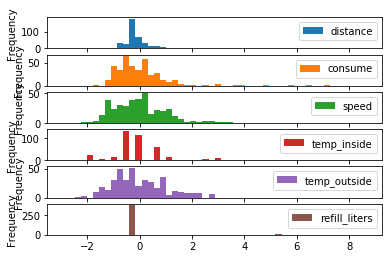

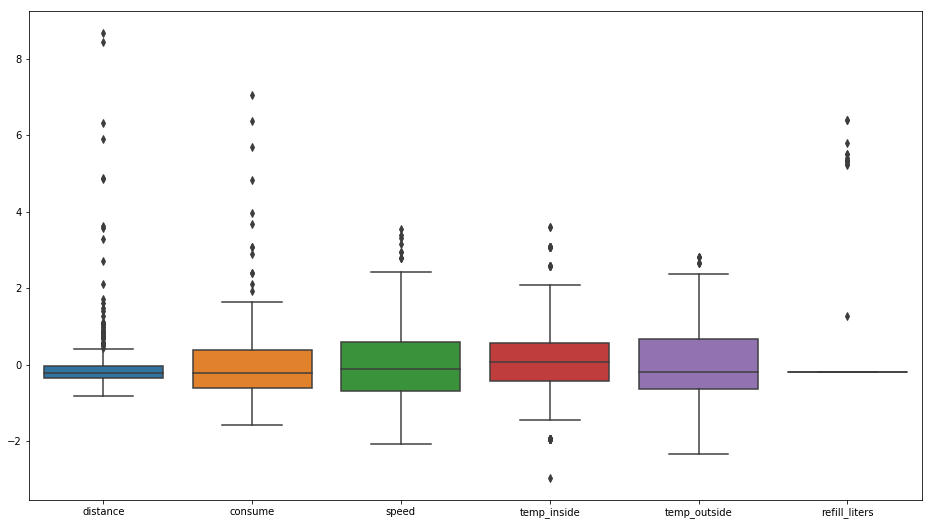

In [10]:
# DAY2
## 外れ値の確認
# ヒストグラムとIQRを使って外れ値を確認する（量的データに適用）

df_norm_num = df1_norm[["distance", "consume", "speed", "temp_inside", "temp_outside", "refill_liters"]]

plt.figure(figsize=(16,16))
df_norm_num.plot(kind='hist', bins=50, subplots=True);
plt.show()

plt.figure(figsize=(16,9))
sns.boxplot(data=df_norm_num)
plt.show()


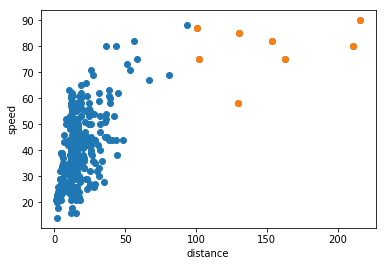

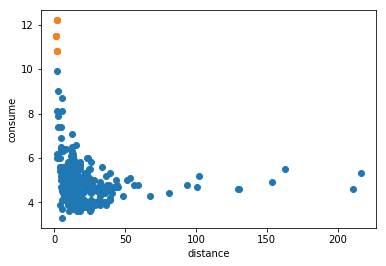

Text(0.5, 1.0, 'remove outlier')

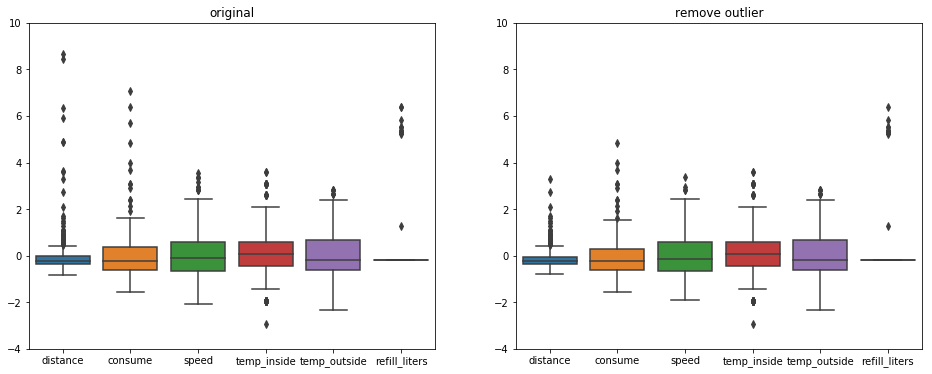

In [11]:
# DAY2
##　外れ値を定義し除外
#　１．distanceで外れ値の割合が高い。走行距離が長いロングトリップ(100km以上、平均値は20km)ものを排除　
#　⇒　distance長いとspeedの外れ値も取り除ける可能性大。
plt.plot(df['distance'].values, df['speed'].values, 'o')
temp1 = df.query('distance>100')
plt.plot(temp1['distance'].values, temp1['speed'].values, 'o')
plt.xlabel('distance')
plt.ylabel('speed')
plt.show()

#　２．consumeの値が大きすぎるものがある。10>L/100kmのものを排除(平均5L/100km)　
#　⇒　傾向としては走行距離がかなり少ないとき(2kmぐらい)
plt.plot(df['distance'].values, df['consume'].values, 'o')
temp2 = df.query('consume>10')
plt.plot(temp2['distance'].values, temp2['consume'].values, 'o')
plt.xlabel('distance')
plt.ylabel('consume')
plt.show()

#　外れ値を除外後IQRを表示
ind_dis = (100-df['distance'].mean())/np.std(df['distance'])
df_norm_num_iqr = (df_norm_num[df_norm_num['distance'] < ind_dis])
ind_con = (10-df['consume'].mean())/np.std(df['consume'])
df_norm_num_iqr = (df_norm_num_iqr[df_norm_num_iqr['consume'] < ind_con])
#df_norm_num_iqr = df_norm_num.query('distance > ind_dis')


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.ylim([-4,10])
plt.title("original")
sns.boxplot(data=df_norm_num)
plt.subplot(1,2,2)
plt.ylim([-4,10])
sns.boxplot(data=df_norm_num_iqr)
plt.title("remove outlier")
# plt.title("外れ値除外後", fontproperties=fp)



コメント：  
ボックスプロットの可視化で、外れ値削除後の方が、データのまとまりがみられる。外れ値の閾値をどのくらいに設定するかは難しいところ。後に、外れ値考慮ありなしで、予測精度を比較してみたい。

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,0.368714,0.084925,-1.172804,-0.432382,0.091908,0,0,0,0,6.390062
1,-0.338044,-0.690390,-0.878274,-0.432382,0.235123,0,0,0,0,-0.181605
2,-0.373381,0.569497,-0.289216,-0.432382,0.521552,0,0,0,0,-0.181605
3,-0.298288,-0.981133,-0.436480,-0.432382,0.378338,0,0,0,0,-0.181605
4,-0.050923,-0.399647,0.299843,-0.432382,0.521552,0,0,0,0,-0.181605


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,1.017449,0.162829,-1.233619,-0.428419,0.100479,0,0,0,0,6.675309
1,-0.464299,-0.765511,-0.911545,-0.428419,0.243966,0,0,0,0,-0.176702
2,-0.538386,0.743041,-0.267398,-0.428419,0.530941,0,0,0,0,-0.176702
3,-0.380951,-1.113639,-0.428435,-0.428419,0.387453,0,0,0,0,-0.176702
4,0.137661,-0.417384,0.376749,-0.428419,0.530941,0,0,0,0,-0.176702


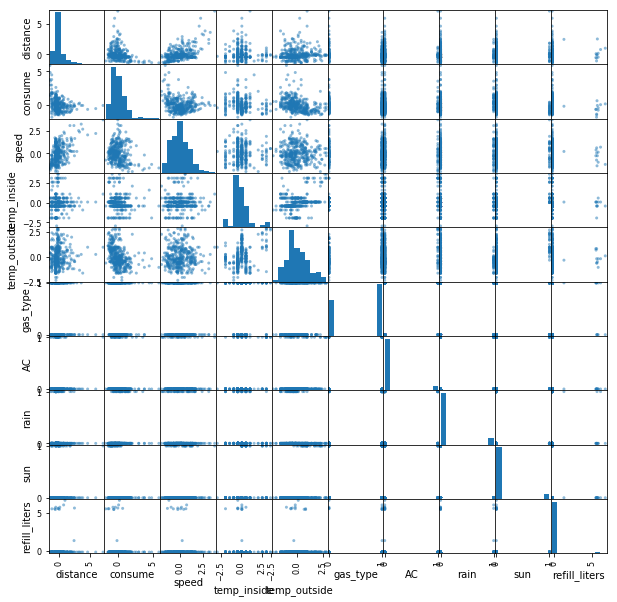

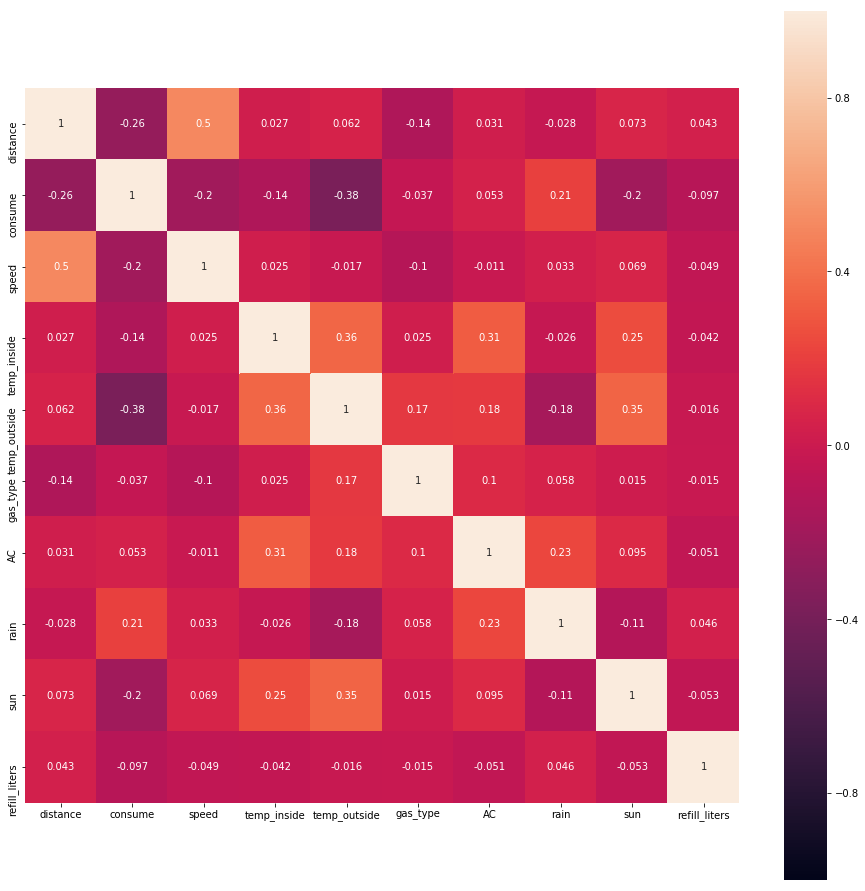

In [12]:
# DAY2
## 前処理実施後のデータ確認

ind_dis = (100-df['distance'].mean())/np.std(df['distance'])
df1_norm_iqr = (df1_norm[df1_norm['distance'] < ind_dis])
ind_con = (10-df['consume'].mean())/np.std(df['consume'])
df1_norm_iqr = (df1_norm_iqr[df1_norm_iqr['consume'] < ind_con])

ind_dis = (100-df['distance'].mean())/np.std(df['distance'])
df2_norm_iqr = (df2_norm[df2_norm['distance'] < ind_dis])
ind_con = (10-df['consume'].mean())/np.std(df['consume'])
df2_norm_iqr = (df2_norm_iqr[df2_norm_iqr['consume'] < ind_con])

# 外れ値抜いた分、再度標準化
df1_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df1_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])
df2_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df2_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])


# データ確認
display(df1_norm.head())
df1_norm_iqr.describe()

display(df1_norm_iqr.head())
df2_norm_iqr.describe()


# 散布図
pd.plotting.scatter_matrix(df1_norm_iqr, figsize=(10,10))
plt.show()

# 相関マトリクスヒートマップ
plt.figure(figsize=(16,16))
heatmap = sns.heatmap(df1_norm_iqr.corr(), cbar=True, annot=True, square=True,
                      vmin=-1.0, vmax=1.0)


C:\Users\QD457275\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\QD457275\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\QD457275\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'distance:power_transfer')

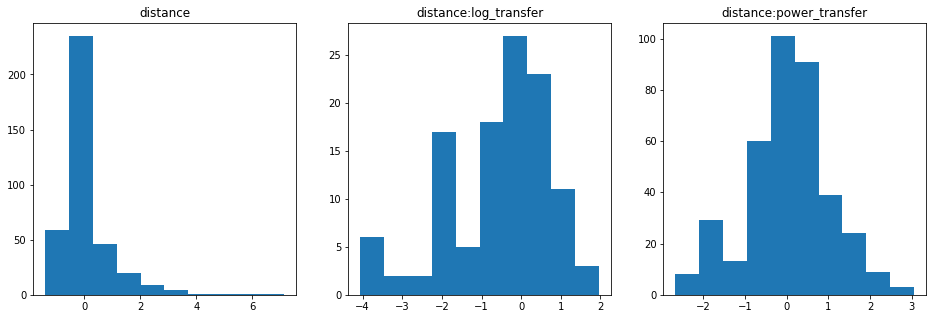

In [13]:
# DAY3  (DAY2の指摘を反映)
## distanceの分布がべき乗の形をとっているみたいなので、対数や指数変換して分布改善を試みる

from sklearn.preprocessing import PowerTransformer

# 対数変換
df_distance_log = np.log(df1_norm_iqr['distance']).copy()

# 指数変換
pt = PowerTransformer()
d = df1_norm_iqr['distance'].values.reshape([-1,1])
clf = pt.fit(d)
df_distance_pow = pt.transform(d)


# ヒストグラム表示
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.hist(df1_norm_iqr['distance'].values)
plt.title('distance')

plt.subplot(1,3,2)
plt.hist(df_distance_log)
plt.title('distance:log_transfer')

plt.subplot(1,3,3)
plt.hist(df_distance_pow)
plt.title('distance:power_transfer')

In [14]:
# DAY3
## consumeは標準化からリアルな値へ戻しておく
df1_norm.loc[:,['consume']] = df['consume'].copy()
df2_norm.loc[:,['consume']] = df['consume'].copy()
df1_norm_iqr.loc[:,['consume']] = df['consume'].copy()
df2_norm_iqr.loc[:,['consume']] = df['consume'].copy()

##　distanceを対数変換し正規化 
df1_norm_iqr_pow = df1_norm_iqr.copy()
df1_norm_iqr_pow.loc[:,['distance']] = df_distance_pow


##　最終データの確認
display(df1_norm_iqr_pow.head())
df1_norm_iqr_pow.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,1.226832,5.0,-1.233619,-0.428419,0.100479,0,0,0,0,6.675309
1,-0.407698,4.2,-0.911545,-0.428419,0.243966,0,0,0,0,-0.176702
2,-0.549239,5.5,-0.267398,-0.428419,0.530941,0,0,0,0,-0.176702
3,-0.256681,3.9,-0.428435,-0.428419,0.387453,0,0,0,0,-0.176702
4,0.487967,4.5,0.376749,-0.428419,0.530941,0,0,0,0,-0.176702


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
count,3.770000e+02,377.000000,3.770000e+02,3.770000e+02,3.770000e+02,377.000000,377.000000,377.000000,377.000000,3.770000e+02
mean,-1.096051e-17,4.859682,-8.834666e-18,9.588557e-16,-5.477493e-16,0.588859,0.076923,0.119363,0.082228,1.958351e-17
std,1.001329e+00,0.862898,1.001329e+00,1.001329e+00,1.001329e+00,0.492695,0.266823,0.324646,0.275077,1.001329e+00
min,-2.669325e+00,3.300000,-2.038803e+00,-2.949647e+00,-2.338803e+00,0.000000,0.000000,0.000000,0.000000,-1.767023e-01
25%,-4.424393e-01,4.300000,-6.699901e-01,-4.284195e-01,-6.169568e-01,0.000000,0.000000,0.000000,0.000000,-1.767023e-01
50%,-3.907496e-02,4.700000,-1.063612e-01,7.582608e-02,-1.864953e-01,1.000000,0.000000,0.000000,0.000000,-1.767023e-01
75%,5.087011e-01,5.200000,6.988229e-01,5.800716e-01,6.744278e-01,1.000000,0.000000,0.000000,0.000000,-1.767023e-01
max,3.052166e+00,9.900000,3.758523e+00,3.605545e+00,2.826736e+00,1.000000,1.000000,1.000000,1.000000,6.675309e+00


# データフレームの整理
・df1　⇒　specialsの代わりにAC、rain、sunを使用  
・df2　⇒　specialsをonehot化し、AC、rain、sunを排除  
※なぜか、df1,df2も正規化された状態になっている。原因不明・・・  
・df1_norm, df2_norm　⇒　df1,df2の量的データを標準化  
・df1_norm_iqr, df2_norm_iqr　⇒　df1,df2の量的データを標準化し、さらに外れ値を定義して排除  
・df1_norm_iqr_powは'distance'変数をPowerTransfer実施


# 予測モデルの構築　
 
 ４-１．特徴量選択と線形回帰  
　　　・ステップワイズ法による特徴量選択  
　　　・LASSOによる特徴量選択  
 ４-２．木モデル：  
　　　・決定木  
　　　・ランダムフォレスト  
 ４－３．NN  

Feature ranking: 
[1 5 6 1 4 1 1 2 3]


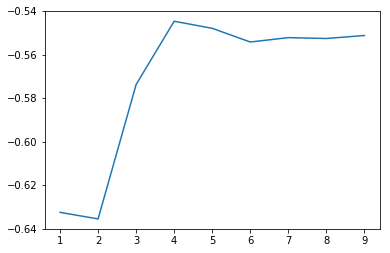

,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,1.226832,-1.233619,-0.428419,0.100479,0,0,0,0,6.675309
1,-0.407698,-0.911545,-0.428419,0.243966,0,0,0,0,-0.176702
2,-0.549239,-0.267398,-0.428419,0.530941,0,0,0,0,-0.176702
3,-0.256681,-0.428435,-0.428419,0.387453,0,0,0,0,-0.176702
4,0.487967,0.376749,-0.428419,0.530941,0,0,0,0,-0.176702


In [15]:
# DAY3
### 4-1　埋め込み法特徴量選択と線形回帰

##　データ
train_data = df1_norm_iqr_pow.drop("consume", axis=1).copy()
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数


## ステップワイズ法
from sklearn.feature_selection import RFECV

estimator = LinearRegression(normalize=True)      # 線形回帰モデルを使用
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')  # 負のMAEを誤差関数として使用

# fitで特徴選択を実行
rfecv.fit(X, y)

# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


display(df1_norm_iqr_pow.drop("consume", axis=1).head())

In [16]:
## ランキング１以外の変数を削除

#　1をTure、1以外をFalseで技術
rfecv.support_
remove_idx = ~rfecv.support_
remove_idx

remove_feature = train_data.columns[remove_idx]
remove_feature

#　削除対象の特徴の名前取得
remove_feature = train_data.columns[remove_idx]
remove_feature

# drop関数で特徴を削除
selected_train_data = train_data.drop(remove_feature, axis=1)
display(selected_train_data.head())

,distance,temp_outside,AC,rain
0,1.226832,0.100479,0,0
1,-0.407698,0.243966,0,0
2,-0.549239,0.530941,0,0
3,-0.256681,0.387453,0,0
4,0.487967,0.530941,0,0


In [17]:
##　ステップワイズ法で選択した特徴量だけを用いて線形回帰分析
# 係数を求める
y = df1_norm_iqr_pow["consume"].values     #目的変数
X = selected_train_data.values             #説明変数
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)


### 精度検証
# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE_stepwise = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE_stepwise = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE_stepwise = %s"%round(rmse, 3) )


MSE_stepwise = 0.506
MAE_stepwise = 0.534
RMSE_stepwise = 0.711


In [18]:
##　データ
train_data = df1_norm_iqr_pow.drop("consume", axis=1).copy()
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数


## LASSOで特徴量選択
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

estimator = LassoCV(normalize=True, cv=10)        # 線形回帰モデルを使用
sfm = SelectFromModel(estimator, threshold=1e-1)  # 係数の閾値はデフォルト値

# fitで特徴選択を実行
sfm.fit(X, y)

# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
print(abs_coef)



# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]


[0.31565721 0.02781134 0.02235325 0.2592881  0.07424944 0.30549814
 0.3442532  0.19152903 0.07597553]


Index(['speed', 'temp_inside', 'gas_type', 'refill_liters'], dtype='object')

# まとめ（特徴量選択）
ステップワイズ法とLASSO(閾値0.1)により特徴量選択を行った結果  
寄与が少ない係数：'speed', 'temp_inside', 'gas_type', 'refill_liters'  
寄与が大きい係数：'distance', 'outside_temp', 'AC', 'rain'  
となった。  
４つの特徴量のみを選択して回帰分析を行った結果、
MAEの改善度は 0.549 ⇒　0.534 と多少の改善を見せた。  

In [19]:
# DAY3
### 4-2　木モデル分析(回帰木)

##　データ
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数
# X = selected_train_data.values                          #説明変数

#　ホールドアウト法でデータの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
# scikit-learnのtrain_test_split関数を使って学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


##　決定木(回帰木)
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = DecisionTreeRegressor(criterion="mae", max_depth=4, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)

print("Training score=", clf.score(X_train, y_train))
print(clf.predict(X_test)) #予測したい場合
print("Test score=", clf.score(X_test, y_test))


Training score= 0.5367035157476976
[4.9  4.9  5.1  4.9  5.1  4.5  4.9  4.9  4.9  4.5  4.5  4.5  4.9  7.4
 4.9  4.5  6.   4.   4.   4.9  4.9  5.1  4.   4.9  4.9  6.   4.85 4.5
 4.9  4.9  4.85 4.85 4.5  4.9  4.85 4.9  4.9  4.9  5.4  4.   4.9  4.
 9.   5.1  5.1  4.5  4.5  5.1  4.   4.5  4.9  5.4  4.9  4.5  4.9  4.9
 4.9  5.1  4.9  5.1  5.4  5.1  4.   5.4  4.9  4.5  4.   4.9  4.5  4.9
 6.   4.5  4.9  4.9  6.   4.5 ]
Test score= 0.5141242937853108


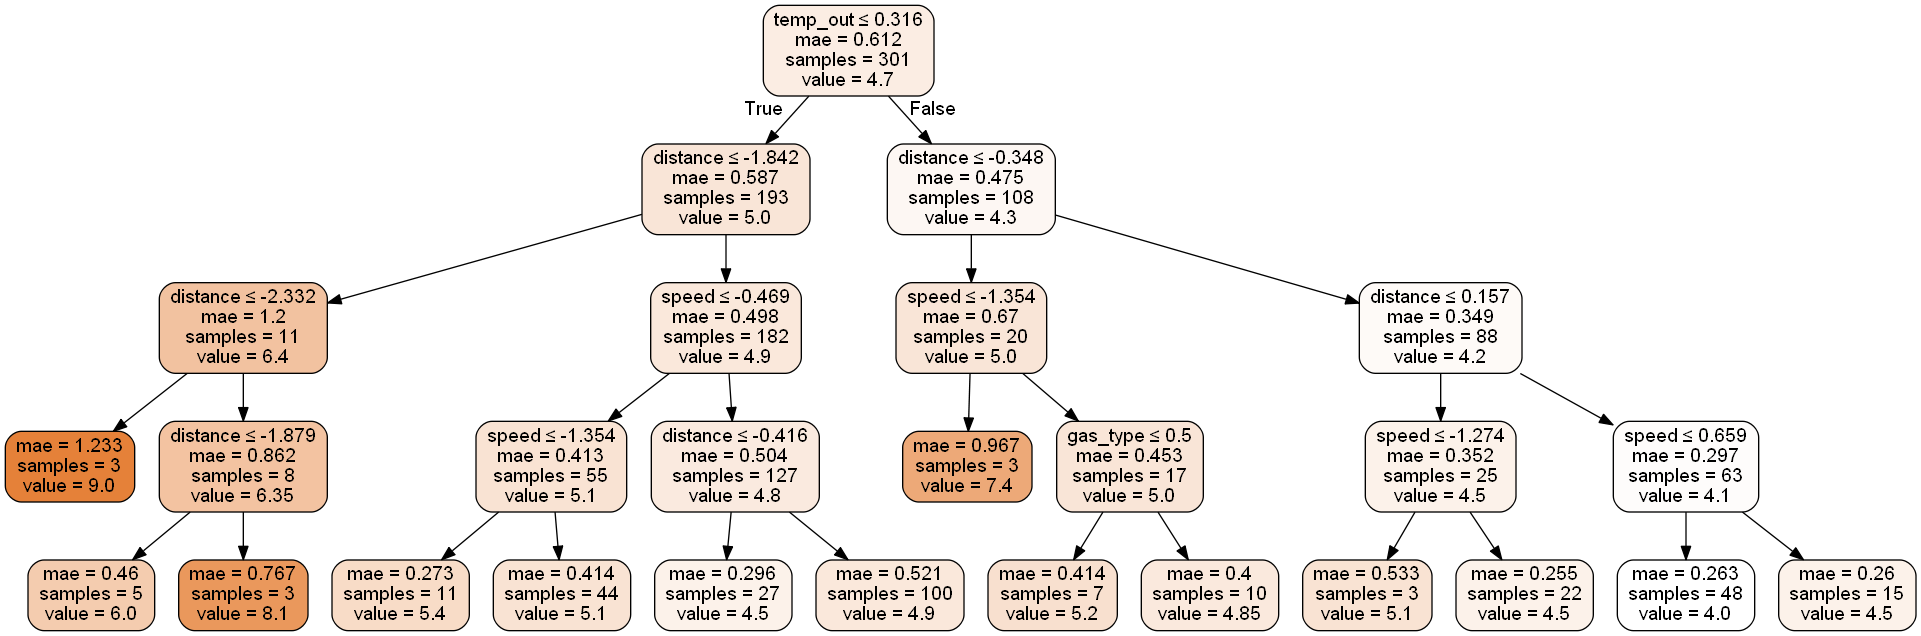

In [20]:
## 決定木の描画
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image

dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=["distance", "speed", "temp_in", "temp_out", "gas_type", "AC", "rain", "sun", "refill_liters"],  
                     class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 

# export_graphviz(clf, out_file=dot_data,  
#                      feature_names=["distance", "temp_out", "AC", "rain"],  
#                      class_names=["0","1"],  
#                      filled=True, rounded=True,  
#                      special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())


In [21]:
# DAY3
### 4-2　木モデル分析(回帰木)

##　データ
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数
# X = selected_train_data.values                          #説明変数

#　CVでデータ分割
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_score = 0
split_num = 0

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    ##　決定木(回帰木)
    # from sklearn.tree import DecisionTreeClassifier, export_graphviz
    from sklearn.tree import DecisionTreeRegressor, export_graphviz

    clf = DecisionTreeRegressor(criterion="mae", max_depth=4, min_samples_split=3, min_samples_leaf=3, random_state=1234)
    clf = clf.fit(X_train, y_train)
    
    cross_valid_score += clf.score(X_test, y_test)     #後で平均を取るためにscoreを加算
    split_num += 1

    print("Fold %s"%split_num)
    print("Training score=", clf.score(X_train, y_train))
    print("Test score=", clf.score(X_test, y_test))
    #     print(clf.predict(X_test)) #予測したい場合

# scoreの平均値を最終的な値とする
final_score = cross_valid_score / n_split
print("Cross Validation Score = %s"%round(final_score, 3))

Fold 1
Training score= 0.6000717375694696
Test score= 0.2987609644657251
Fold 2
Training score= 0.5919755995712582
Test score= 0.2591611294814691
Fold 3
Training score= 0.5954843889298094
Test score= 0.2794102614245461
Fold 4
Training score= 0.6257633873641425
Test score= -0.1682348383536052
Fold 5
Training score= 0.528962269187297
Test score= -0.19708444912619183
Cross Validation Score = 0.094


# まとめ（回帰木）
回帰木×ホールドアウト法で燃費を予測：木の深さをNoneにすると訓練精度は増すが汎化精度が減少する　⇒　過学習の傾向がみられる。  
木の深さを４層にして解析すると訓練精度と汎化精度が0.5ぐらいで落ち着くが予測精度はまだまだといった言った感じ。  

回帰木×CVで燃費予測：訓練精度は0.6近傍を得るが、汎化精度が悪く不安定。回帰木モデルの問題は難しい印象を持った。

Fold 1
Training score= 0.46349734225169104
Test score= 0.2714221855043121
Fold 2
Training score= 0.512989321529107
Test score= 0.18749715752031423
Fold 3
Training score= 0.451655499114242
Test score= 0.3285644483506519
Fold 4
Training score= 0.5080541071634459
Test score= 0.24469382177503252
Fold 5
Training score= 0.4522058940869126
Test score= -0.18754085071008775
Cross Validation Score = 0.169
[0.58593498 0.13125363 0.         0.27040263 0.01240876 0.
 0.         0.         0.        ]


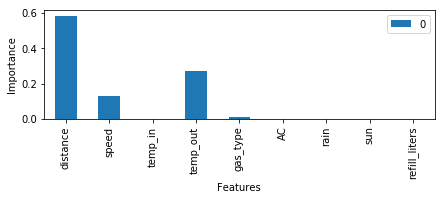

In [22]:
# DAY3
### 4-2　木モデル分析(回帰木ランダムフォレスト)


##　データ
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数
# X = selected_train_data.values                          #説明変数

#　CVでデータ分割
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_score = 0
split_num = 0

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    ##　ランダムフォレスト(回帰木)
    # from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor

    
    
    clf = RandomForestRegressor(n_estimators=10, max_depth=2, criterion="mae",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
    
    clf.fit(X_train, y_train)
    cross_valid_score += clf.score(X_test, y_test)     #後で平均を取るためにscoreを加算
    
    split_num += 1
    
    print("Fold %s"%split_num)
    print("Training score=", clf.score(X_train, y_train))
    print("Test score=", clf.score(X_test, y_test))
    

# scoreの平均値を最終的な値とする
final_score = cross_valid_score / n_split
print("Cross Validation Score = %s"%round(final_score, 3))

    
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=["distance", "speed", "temp_in", "temp_out", "gas_type", "AC", "rain", "sun", "refill_liters"]).plot.bar(figsize=(7,2))
# pd.DataFrame(clf.feature_importances_, index=["distance", "temp_out", "AC", "rain"]).plot.bar(figsize=(7,2))

plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()


# まとめ（ランダムフォレスト回帰）
ランダムフォレスト×クロスバリデーション法で燃費を予測。木の深さを２とし、10並列の弱識別モデルを作成。訓練精度が0.5付近に対し、平均汎化精度が0.2未満。回帰木と同じく未だ精度が出ない。変数の重要度は"distance"と"temp_out"が大きい傾向。

Fold 1
Training score= 0.6613583677514399
Test score= 0.38417277069600475
Fold 2
Training score= 0.6225673222060677
Test score= 0.354887500391167
Fold 3
Training score= 0.6782381614966679
Test score= 0.48382874514440133
Fold 4
Training score= 0.6553642013658395
Test score= 0.1674228915918402
Fold 5
Training score= 0.5920757342925093
Test score= -0.1027312070869244
Cross Validation Score = 0.258
[0.50987904 0.16770145 0.05738114 0.16777116 0.00803956 0.
 0.04755037 0.01544847 0.02622881]


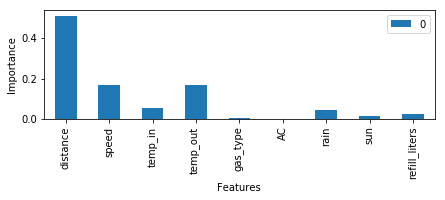

In [23]:
# DAY3
### 4-2　木モデル分析(回帰木アダブースト法)


##　データ
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数
# X = selected_train_data.values                          #説明変数

#　CVでデータ分割
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_score = 0
split_num = 0


# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    ##　アダブースト法(回帰木)
    # from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.tree import DecisionTreeRegressor
    
    
    clf = AdaBoostRegressor(DecisionTreeRegressor(criterion="mae", max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234),
                                           n_estimators=10, random_state=1234)
    clf.fit(X_train, y_train)
    cross_valid_score += clf.score(X_test, y_test)     #後で平均を取るためにscoreを加算
    
    split_num += 1
    
    print("Fold %s"%split_num)
    print("Training score=", clf.score(X_train, y_train))
    print("Test score=", clf.score(X_test, y_test))
    

# scoreの平均値を最終的な値とする
final_score = cross_valid_score / n_split
print("Cross Validation Score = %s"%round(final_score, 3))

    
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=["distance", "speed", "temp_in", "temp_out", "gas_type", "AC", "rain", "sun", "refill_liters"]).plot.bar(figsize=(7,2))
# pd.DataFrame(clf.feature_importances_, index=["distance", "temp_out", "AC", "rain"]).plot.bar(figsize=(7,2))

plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

# まとめ（アダブースト法回帰木）
アダブースト回帰木×CVで燃費を予測。ランダムフォレストに比べ精度は良い結果になったが、汎化精度が0.25付近と実用的に使うには課題が多い。
説明変数の重要度の結果も"distance"と"temp_out"が大きい値を取った。

In [24]:
# DAY3
### 4-3　Neural　Network　（ホールドアウト法で検証）


##　データ
y = df1_norm_iqr_pow["consume"].values                  #目的変数
X = df1_norm_iqr_pow.drop("consume", axis=1).values     #説明変数
# X = selected_train_data.values                        #説明変数


##　ホールドアウト法でデータの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）

# scikit-learnのtrain_test_split関数を使って学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


##　NNモデル作成
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
# model.add(Dense(9, activation='relu', input_dim=9))       # 中間層1と入力次元の指定
# model.add(Dense(9, activation='relu'))                    # 中間層2
# model.add(Dense(1, activation='linear'))                  #最終層のactivationは変更しないこと

model.add(Dense(9, activation='relu', input_dim=9))       # 中間層1と入力次元の指定
model.add(Dense(5, activation='relu'))                    # 中間層2
model.add(Dense(5, activation='relu'))                    # 中間層3
model.add(Dense(9, activation='relu'))                    # 中間層4
model.add(Dense(1, activation='linear'))                  #最終層のactivationは変更しないこと


# model.add(Dense(6, activation='sigmoid', input_dim=9))       # 中間層1と入力次元の指定
# model.add(Dense(3, activation='sigmoid'))                    # 中間層2
# model.add(Dense(1, activation='linear'))                  #最終層のactivationは変更しないこと

# ------ 最適化手法 ------
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)            #最初につかってみるとよい
# -----------------------------

# 回帰問題なので損失関数にはmse or maeを使用
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['mse'])
# model.compile(loss='mean_absolute_error',
#               optimizer=adam,
#               metrics=['mae'])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Train on 301 samples, validate on 76 samples
Epoch 1/500
301/301 [==============================] - 1s 3ms/step - loss: 19.5297 - mean_squared_error: 19.5297 - val_loss: 10.9291 - val_mean_squared_error: 10.9291
Epoch 2/500
301/301 [==============================] - 0s 93us/step - loss: 4.5326 - mean_squared_error: 4.5326 - val_loss: 2.6154 - val_mean_squared_error: 2.6154
Epoch 3/500
301/301 [==============================] - 0s 105us/step - loss: 1.1060 - mean_squared_error: 1.1060 - val_loss: 0.8156 - val_mean_squared_error: 0.8156
Epoch 4/500
301/301 [==============================] - 0s 107us/step - loss: 0.7092 - mean_squared_error: 0.7092 - val_loss: 0.5564 - val_mean_squared_error: 0.5564
Epoch 5/500
301/301 [==============================] - 0s 100us/step - loss: 0.5214 - mean_squared_error: 0.5214 - val_loss: 0.5368 - val_mean_squared_error: 0.5368
Epoch 6/500
301/301 [==============================] - 0s 100us/step - loss: 0.48

301/301 [==============================] - 0s 90us/step - loss: 0.3310 - mean_squared_error: 0.3310 - val_loss: 0.3502 - val_mean_squared_error: 0.3502
Epoch 49/500
301/301 [==============================] - 0s 103us/step - loss: 0.3233 - mean_squared_error: 0.3233 - val_loss: 0.3235 - val_mean_squared_error: 0.3235
Epoch 50/500
301/301 [==============================] - 0s 107us/step - loss: 0.3271 - mean_squared_error: 0.3271 - val_loss: 0.3275 - val_mean_squared_error: 0.3275
Epoch 51/500
301/301 [==============================] - 0s 113us/step - loss: 0.3205 - mean_squared_error: 0.3205 - val_loss: 0.3201 - val_mean_squared_error: 0.3201
Epoch 52/500
301/301 [==============================] - 0s 97us/step - loss: 0.3195 - mean_squared_error: 0.3195 - val_loss: 0.3203 - val_mean_squared_error: 0.3203
Epoch 53/500
301/301 [==============================] - 0s 97us/step - loss: 0.3192 - mean_squared_error: 0.3192 - val_loss: 0.3192 - val_mean_squared_error: 0.3192
Epoch 54/500
301/301

301/301 [==============================] - 0s 110us/step - loss: 0.4613 - mean_squared_error: 0.4613 - val_loss: 0.3745 - val_mean_squared_error: 0.3745
Epoch 98/500
301/301 [==============================] - 0s 87us/step - loss: 0.3660 - mean_squared_error: 0.3660 - val_loss: 0.3617 - val_mean_squared_error: 0.3617
Epoch 99/500
301/301 [==============================] - 0s 103us/step - loss: 0.3082 - mean_squared_error: 0.3082 - val_loss: 0.3475 - val_mean_squared_error: 0.3475
Epoch 100/500
301/301 [==============================] - 0s 103us/step - loss: 0.3099 - mean_squared_error: 0.3099 - val_loss: 0.3533 - val_mean_squared_error: 0.3533
Epoch 101/500
301/301 [==============================] - 0s 90us/step - loss: 0.2957 - mean_squared_error: 0.2957 - val_loss: 0.4656 - val_mean_squared_error: 0.4656
Epoch 102/500
301/301 [==============================] - 0s 87us/step - loss: 0.3318 - mean_squared_error: 0.3318 - val_loss: 0.3419 - val_mean_squared_error: 0.3419
Epoch 103/500
301

,val_loss,val_mean_squared_error,loss,mean_squared_error
0,10.929139,10.929139,19.529714,19.529714
1,2.615391,2.615391,4.532647,4.532647
2,0.815578,0.815578,1.106000,1.106000
3,0.556353,0.556353,0.709150,0.709150
4,0.536822,0.536822,0.521436,0.521436


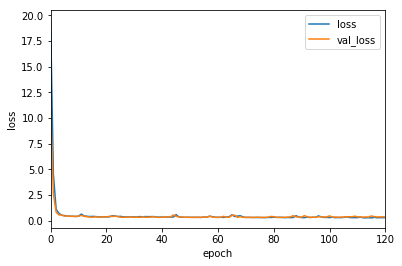

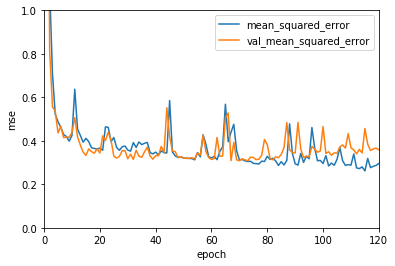

In [25]:
## 計算の実行
from keras.callbacks import EarlyStopping, CSVLogger

es = EarlyStopping(monitor='val_loss', patience=50)

fit = model.fit(X_train, y_train,
          epochs=500,
          batch_size=20,validation_data=(X_test, y_test),
          callbacks=[es])

## 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)
display(df.head())

## グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
df[["mean_squared_error", "val_mean_squared_error"]].plot()
plt.ylabel("mse")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()
# df[["loss", "val_loss"]].plot()
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.show()
# df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
# plt.ylabel("mae")
# plt.xlabel("epoch")
# plt.ylim([0,1.0])
# plt.show()

In [26]:
## 計算結果の重みを表示する
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()

weights[0]=
[[-0.5583476  -0.5495828   0.38312277  0.35502025  0.01404523  0.5080848
   0.31577337  0.5133856  -0.9590301 ]
 [-0.958921    0.6104232  -0.20237069  0.37324125 -0.3073487  -0.4587511
  -0.64330137  0.09574999  0.10279873]
 [-0.02970167 -0.43990925  0.513671    0.09254393  0.54427695 -0.31264386
   0.15102364 -0.16345489  0.7170318 ]
 [ 0.09016027 -0.8766366   0.02078555  0.09728642 -0.98147076 -0.11819534
  -0.7971234  -0.4218544   0.25061396]
 [-0.22533067 -0.09800853  0.25801012  0.10657419  0.04361675 -0.10047911
   0.3904242  -1.1275449  -0.57604444]
 [ 0.14041865 -2.0215774  -0.7981405  -0.08722091  0.1512143  -0.51961714
   0.30975005  0.400107    0.12575503]
 [-0.9466164   0.2918464  -1.3566222   0.7560054  -0.7115717   0.0663716
   0.19716594  1.2391516  -0.30194405]
 [-1.3389318  -0.29494157  0.6408654   0.21106873  0.9927257  -0.60777587
   0.3843759  -0.07399868  0.39762926]
 [ 0.16132459 -0.6283681   0.04961159 -0.85265356 -0.14177833  0.6408376
   0.08957037 

In [27]:
##　計算したKerasモデルの保存
from keras.models import load_model

# 保存
model.save('car_consume_shio_model1.h5')
del model

# 読み込み
model = load_model('car_consume_shio_model1.h5')

In [28]:
##　学習モデルを使ってtestデータの予測

# y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred = model.predict(X_test)
y_pred

# MSEを計算
mse = mean_squared_error(y_test, y_pred)
print("MSE = %s"%round(mse,3) )  
# MAEを計算
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )
# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )


MSE = 0.359
MAE = 0.458
RMSE = 0.599


# まとめ（NN）
NN回帰モデルを実装。中間層にReLU活性化関数、損失関数にMSEを使用した。中間層の数、ephoc数


# 全体のまとめ
燃費の予測結果(MAE指標)：  
consumeの平均値4.9(L/100km)、標準偏差1.0に対して    
　・回帰分析　0.549  
　・回帰分析(特徴量選択後)　0.534  
　・NN(中間層4層、LeRU) 0.42  
  
  
※その他精度が思ったほど得られなかった分析（訓練精度に対して汎化精度が著しく悪い、木モデルは過学習の傾向見られる）  
　・回帰木  
　・ランダムフォレスト回帰木  
　・アダブースト回帰木  
